In [2]:
%load_ext jupyter_black

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.dummy import DummyClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns

# Внутренние меры кластеризации

Или как оценивать, если правильных меток не существует в природе? 



In [ ]:
features, true_labels = make_blobs(
    n_samples=200, centers=3, cluster_std=2.75, random_state=42
)

kmeans = KMeans(n_clusters=3, n_init=10)
kmeans.fit(features)

## Кстати, кто такой Rand Index ?

print("KMeans Rand Index: ", metrics.rand_score(kmeans.labels_, true_labels))

In [ ]:
## А тут вы сколько ожидаете увидеть? А если пар -- 100?
random_labels = np.random.randint(0, 3, size=true_labels.shape)
print("Random Rand Index: ", metrics.rand_score(random_labels, true_labels))

In [ ]:
fig, (left, right) = plt.subplots(1, 2)

left.scatter(
    features[:, 0],
    features[:, 1],
    s=15,
    c=random_labels,
)

right.scatter(
    features[:, 0],
    features[:, 1],
    s=15,
    c=kmeans.labels_,
)

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

print(f"Silhouette score")
print(f"random clustering: {silhouette_score(features, random_labels)}")
print(f"kmeans: {silhouette_score(features, kmeans.labels_)}")

print()

print(f"David-Bouldin Index")
print(f"random clustering: {davies_bouldin_score(features, random_labels)}")
print(f"kmeans: {davies_bouldin_score(features, kmeans.labels_)}")

---

# Как выбрать число кластеров


### Elbow plot
Самый простой метод, продолжающий предыдущую тему.

Какое максимальное и минимальное значения $EV$? Как они достигаются?

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cd/DataClustering_ElbowCriterion.JPG" />

In [ ]:
# !pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(kmeans, k=(1, 9))

visualizer.fit(features)
visualizer.show()  # тут вместо explained variance сырые расстояния

### Silhouette analysis

Выше мы рассмотрели глобальный (усредненный) Silhouette score. Давайте теперь росмотрим на эти коэффициенты, сгруппированные по кластерам

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

# поменять число кластеров и посмотркть картинки
model = KMeans(2, random_state=42, n_init=10)
visualizer = SilhouetteVisualizer(model, colors="yellowbrick")

visualizer.fit(features)
visualizer.show()

---

## Case study: сжатие изображений

Адаптация примера из курса К.В. Воронцова.

Преобразуем изображение, приведя все значения
в интервал [0, 1]: можно использовать функцию `img_as_float` из модуля `skimage`.

In [ ]:
# ! pip install -q --upgrade scikit-image

In [1]:
import numpy as np

import skimage
from skimage import data, io
from skimage.io import imread, imsave
from sklearn.cluster import KMeans

image = imread("Lenna.png")
print(image.shape, image.max(), image.min())

(1024, 1024, 3) 255 0


Каптинка в т.н. "полноцветном" формате, т.е. по 1 байту на каждый из трех каналов.

 **Сколько всего цветов ?**

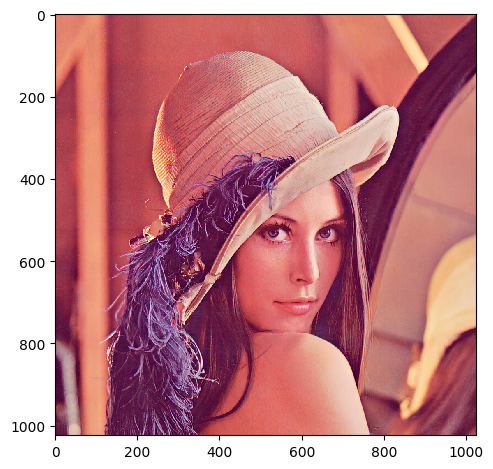

In [2]:
io.imshow(image)

**PSNR - peak signal-to-noise ratio**

Соотношение между максимумом возможного значения сигнала и мощностью шума, искажающего значения сигнала. Поскольку многие сигналы имеют широкий динамический диапазон, PSNR обычно измеряется в логарифмической шкале в децибелах.

PSNR наиболее часто используется для измерения уровня искажений при сжатии изображений. 

$$PSNR = 10 ~ \log_{10} \frac{MAX_{orig}^2}{MSE}$$

Довольно плохая метрика, кстати говоря; как думаете, в чем ее проблема?

In [3]:
def psnr(X_true, X_clustered):

    mse = np.mean((X_true - X_clustered) ** 2)
    max_2 = np.max(X_true) ** 2

    return 10 * np.log10(max_2 / mse)

In [4]:
psnr(image, image + np.ones_like(image) * 0.0000000000001)

np.float64(259.49197063480506)

Кластеризуем, и все пиксели, отнесенные в один кластер, попробуем заполнить двумя способами: медианным и средним цветом по кластеру. Таким образом мы "сжимаем" изображение. 

In [5]:
float_image = skimage.img_as_float(image, force_copy=True)
float_image.shape,

((1024, 1024, 3),)

Переведём в набор троек RGB

In [6]:
RGB = float_image.reshape(-1,3)

RGB.shape, RGB

((1048576, 3),
 array([[0.89019608, 0.52941176, 0.43137255],
        [0.87843137, 0.50980392, 0.42352941],
        [0.87843137, 0.50196078, 0.41960784],
        ...,
        [0.69803922, 0.26666667, 0.30196078],
        [0.70980392, 0.2627451 , 0.30196078],
        [0.7372549 , 0.29019608, 0.32156863]]))

In [7]:
import os
os.makedirs('Lenna', exist_ok=True)

clusters = [256] #+ list(reversed(range(2, 10)))

for n_clusters in clusters:
    
    print(n_clusters, end=" ")
    
    # группируем цвета, которые есть в изображении
    model = KMeans(n_clusters=n_clusters, verbose=False, random_state=100, n_init=10)
    model.fit(RGB)
    X = RGB.copy()
    
    # запоминаем метки кластеров
    labels = model.labels_.T

    for cluster in range(n_clusters):
        
        # по каким индексам в списке пикселей живёт этот кластер?
        args = (cluster == labels)
        
        # заполняем заполненное средним
        X[args, :] = model.cluster_centers_[cluster, :]
        
    # обратно в трёхмерный вид
    im = X.reshape(1024, 1024, 3)
    
    print(f"Frobenius norm: {np.linalg.norm(im - float_image):3.2f}" , end=" | ")    
    print(f"PSNR: {psnr(float_image, im):3.3f}" % psnr(float_image, im))
    
    rescaled_im = (im * 255).astype(np.uint8)
    
    # сохраняем
    imsave("Lenna/" + str(n_clusters) + ".png", rescaled_im)

256 


KeyboardInterrupt



In [ ]:
labels

In [ ]:
image = imread("Lenna/256.png")
io.imshow(image)

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i, c in enumerate(clusters):
    img = imread(f"Lenna/{c}.png")
    ax = fig.add_subplot(3, 3, i+1)
    ax.title.set_text(f'{c} clusters')
    plt.imshow(img)
plt.show()


---
## Case study 2: слова

In [ ]:
# ! wget http://vectors.nlpl.eu/repository/20/182.zip
# ! bash -c "unzip -o 182.zip"

Есть три файла - `meta.json` с метаданными, `lemma.num` с частотами слов и `model.txt` собственно с эмбеддингами.

Давайте кластеризовывать слова на основе их векторных представлений.

In [3]:
! bash -c "tail -2 model.txt"

человечка_NOUN -0.29234073 0.03835703 0.10110392 -0.27563456 -0.15668419 0.17093626 0.16657482 0.426764 0.05025494 -0.3600553 0.41330293 -0.40945807 -0.1383572 0.18148145 -0.14004365 -0.22425707 -0.02813618 0.12828286 -0.07121982 0.08036167 -0.39346257 0.14418003 -0.112279825 0.050379105 0.65719825 0.28230706 -0.19728823 -0.22937453 -0.37179834 -0.48536462 0.03138419 -0.022372728 -0.07253032 -0.0072454247 0.054911043 0.22537158 0.105023034 0.13699752 0.25621888 -0.1780083 -0.2054968 -0.34535745 0.0049650734 0.3966938 0.08922703 -0.1604564 -0.120386116 -0.08408959 0.33405817 0.15972129 -0.01776049 -0.28450355 -0.34316248 0.08639362 -0.35194418 0.33855405 -0.31983042 0.37213647 0.2329898 0.025947459 0.0820079 -0.3286245 -0.3904638 -0.024789961 -0.21230644 0.5233826 0.37559277 -0.089096 0.0084660575 0.14825182 -0.21078822 0.32954386 0.049764797 -0.063024566 0.06718298 -0.04196897 -0.025229331 -0.35419548 0.22244026 0.08812005 -0.29118997 0.041034646 -0.049780015 0.26969633 0.15984987 0.46

In [4]:
# ! pip install nltk
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
STOPS = set(stopwords.words("russian"))
STOPS

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arabella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'а',
 'без',
 'более',
 'больше',
 'будет',
 'будто',
 'бы',
 'был',
 'была',
 'были',
 'было',
 'быть',
 'в',
 'вам',
 'вас',
 'вдруг',
 'ведь',
 'во',
 'вот',
 'впрочем',
 'все',
 'всегда',
 'всего',
 'всех',
 'всю',
 'вы',
 'где',
 'да',
 'даже',
 'два',
 'для',
 'до',
 'другой',
 'его',
 'ее',
 'ей',
 'ему',
 'если',
 'есть',
 'еще',
 'ж',
 'же',
 'за',
 'зачем',
 'здесь',
 'и',
 'из',
 'или',
 'им',
 'иногда',
 'их',
 'к',
 'как',
 'какая',
 'какой',
 'когда',
 'конечно',
 'кто',
 'куда',
 'ли',
 'лучше',
 'между',
 'меня',
 'мне',
 'много',
 'может',
 'можно',
 'мой',
 'моя',
 'мы',
 'на',
 'над',
 'надо',
 'наконец',
 'нас',
 'не',
 'него',
 'нее',
 'ней',
 'нельзя',
 'нет',
 'ни',
 'нибудь',
 'никогда',
 'ним',
 'них',
 'ничего',
 'но',
 'ну',
 'о',
 'об',
 'один',
 'он',
 'она',
 'они',
 'опять',
 'от',
 'перед',
 'по',
 'под',
 'после',
 'потом',
 'потому',
 'почти',
 'при',
 'про',
 'раз',
 'разве',
 'с',
 'сам',
 'свою',
 'себе',
 'себя',
 'сейчас',
 'со',
 'совсем',
 'так

In [5]:
! bash -c "head -2 lemma.num"

1 36358.94 � misc
2 27792.36 � prep


In [6]:
for line in open("lemma.num", "r", encoding="cp1251"):
    print(line)
    break

1 36358.94 и misc



In [7]:
# выбрасываем стоп-слова
all_words = set(
    [
        line.strip().split()[2] for line in open("lemma.num", "r", encoding="cp1251")
    ]
)
all_words

{'стакан',
 'комиссовать',
 'промедление',
 'стерня',
 'антидепрессант',
 'василек',
 'эго',
 'поголовно',
 'умело',
 'озарять',
 'совершенство',
 'туманность',
 'удавить',
 'всосать',
 'натаскать',
 'крохотный',
 'мастерица',
 'садиться',
 'внять',
 'помалу',
 'перепахать',
 'отослать',
 'пропагандист',
 'милочка',
 'баск',
 'беззаботный',
 'вкупе',
 'седьмой',
 'позабавить',
 'шарик',
 'странствие',
 'подавальщица',
 'привкус',
 'холецистит',
 'несение',
 'схема',
 'рф',
 'фильм',
 'напялить',
 'целинный',
 'бритоголовый',
 'физфак',
 'брюква',
 'завоевание',
 'аппаратный',
 'удостоиться',
 'глубина',
 'бесконечный',
 'толь',
 'маринка',
 'зимовка',
 'раздумывать',
 'глазастый',
 'крикун',
 'вступление',
 'запевать',
 'кастрюлька',
 'впервой',
 'грязь',
 'настойчивый',
 'предмет',
 'известковый',
 'крылатка',
 'упираться',
 'штурмовой',
 'претерпевать',
 'перегрузить',
 'телепатический',
 'втирать',
 'интегральный',
 'четверостишие',
 'поселенец',
 'судебно',
 'двинуться',
 'парень',

In [14]:
freq_list = all_words.difference(STOPS)
len(freq_list)

for i, item in enumerate(freq_list):
    print(item)
    if i == 5:
        break
import numpy as np
from tqdm.notebook import tqdm

потоптаться
отладить
безгрешный
сговорчивый
кухонный
эсер


In [16]:
! head -3 model.txt

248978 300
xxxxxxxx_NUM 0.10170885 0.39118028 -0.11257593 -0.032509774 0.13415325 -0.10420727 0.18764631 0.31528306 0.0054617175 -0.0756099 -0.058216017 -0.26865676 0.264849 -0.12249866 0.18941942 -0.29172096 0.33526236 0.14418572 0.039960083 0.066037506 0.15229152 0.0032615322 -0.06447184 -0.2442574 -0.0466608 0.06508272 -0.16778037 -0.040431403 -0.25564447 0.012807227 -0.008759142 -0.1339805 0.15219116 -0.09124506 -0.12790257 0.17576112 0.034356166 -0.03876014 -0.23735623 0.030722342 -0.21226627 0.08759527 0.28928936 -0.13410698 0.24012111 0.1800567 0.10790692 -0.11263622 0.08743534 -0.11368207 -0.16881642 -0.018189812 0.18392694 -0.0808056 0.0722007 -0.07698488 -0.13961521 -0.08382047 0.23470464 0.30994722 -0.15426192 0.21780322 -0.033626564 0.101241425 -0.2646685 -0.1257962 0.19990994 0.18157874 -0.033957053 0.018765468 -0.15669206 0.23315744 0.32539818 0.010651201 -0.05037956 0.5334344 -0.16015397 0.29518726 0.36854792 -0.13286386 -0.16676986 -0.05025304 0.2985046 0.35015944 0.295

In [8]:
tokens = []
raw_vectors = []

with open("model.txt", "r+", encoding="utf-8") as rf:

    # пропускаем первую строку
    next(rf)

    for line in tqdm(rf):
        # parse line, extract only vectors corresponding to frequent nouns
        line = line.strip().split()
        word, typ = line[0].split("_")

        if typ == "NOUN":
            tokens.append(word)
            raw_vectors.append(np.array([float(x) for x in line[2:]]))


len(tokens), len(raw_vectors)

token2id = {t: i for i, t in enumerate(tokens)}
vectors = np.array(raw_vectors)

0it [00:00, ?it/s]

In [ ]:
# нормализуем?
vectors = ...

In [9]:
vectors.shape, vectors.sum(axis=1).shape, vectors.sum(axis=1)

((57568, 299),
 (57568,),
 array([-0.50364005,  4.28854156,  3.21234789, ...,  3.54429363,
         4.04114492,  9.93035531]))

In [13]:
from scipy.spatial.distance import cosine

king = raw_vectors[token2id["компьютер"]]
queen = raw_vectors[token2id["носок"]]

man = raw_vectors[token2id["мужчина"]]
woman = raw_vectors[token2id["женщина"]]
cosine(king - man, queen - woman)

np.float64(0.6492810114158847)

In [14]:
from sklearn import cluster

mbk_means = cluster.MiniBatchKMeans(
    n_clusters=70,
    batch_size=1000,
    max_iter=10000,
    n_init=20,
    random_state=100,
    reassignment_ratio=0.1,
)
mbk_means.fit(vectors)

mbk_means.labels_

array([26, 59, 23, ..., 33, 16, 60], dtype=int32)

In [15]:
tokens2clusters = {t: c for t, c in zip(tokens, mbk_means.labels_)}
cluster2tokens = {l: [] for l in mbk_means.labels_}

In [16]:
for t, c in tokens2clusters.items():
    cluster2tokens[c].append(t)

for c in sorted(list(cluster2tokens)[:50]):
    print(f"\n>-- Cluster #{c}, {len(cluster2tokens[c])} objects.")
    print(" ".join([w for w in cluster2tokens[c][:100]]))


>-- Cluster #0, 19 objects.
pp микрорегион ed gray1 vol bd pg [р sci phys vols soc bot ss n.s inst math ser china

>-- Cluster #1, 22 objects.
алюминий никель кремний полупроводник вольфрам палладий германий графит галлий цирконий рений молибден бериллия бериллий нитрид ниобия гафний родие скандия иридий легирование кремние

>-- Cluster #3, 2939 objects.
форма тип значение процесс исследование основа точка метод задача код элемент модель теория изменение текст алфавит функция вариант структура категория принцип пространство композиция изображение описание свойство соединение изучение единица анализ явление понятие символ определение термин зависимость характеристика деление плотность планета цикл механизм носитель эффект схема архитектура таблица наблюдение разряд индекс величина фактор подход сигнал взаимодействие стадия строение формула набор обозначение воздействие концепция математика классификация эксперимент сложность частота параметр цифра измерение исток компонент субъект диал

---
### Case study 3: dedublication

Довольно часто бывает нужно избавиться от неточных дубликатов коротких текстов, и никаких особых методов родом из предметной области (или внешних вспомогательных данных) для этого нет. Кроме того, как первое приближение для понимания, о чём вообще все эти короткие тексты, как их можно потом размечать, объединять в группы и так далее, -- может помочь кластеризация. 

In [17]:
items = [
    w.strip()
    for w in open("fallout_possible_items.txt", "r+", encoding="utf-8").readlines()
    if w.strip()
]
len(items)

1008

In [18]:
len(set(items))

323

In [19]:
items = list(set(items))
sorted(items)[:10]

['1 Service rifle 5.56 mm rounds 5.56 mm rounds',
 '20',
 '5 burst',
 '5 burst for cost',
 '5 burst for cost of 20 Action Points',
 '5 mm rounds',
 '5 round burst',
 '5 round burst for cost',
 '5 round burst for cost of 20 Action Points',
 '5.56 mm surplus ammunition more valuable']

In [21]:
import difflib

difflib.SequenceMatcher(a="Living my live", b="Leaving my wife").get_matching_blocks()

[Match(a=0, b=0, size=1),
 Match(a=2, b=3, size=8),
 Match(a=11, b=12, size=1),
 Match(a=13, b=14, size=1),
 Match(a=14, b=15, size=0)]

In [24]:
difflib.SequenceMatcher(a="Living my life", b="Living my life").ratio()

1.0

А нам точно понадобится машинное обучение?

In [30]:
similarity = np.zeros((len(items), len(items)))

for i, str_1 in enumerate(items):
    for j, str_2 in enumerate(items):
        sim = difflib.SequenceMatcher(a=str_1, b=str_2).ratio()
        similarity[i, j] = similarity[j, i] = sim

In [31]:
items.index("5 round burst"), items.index("5 round burst for cost")

(142, 219)

In [32]:
idx = [142, 219, 0, 1, 2]

In [33]:
similarity[idx, :][:, idx]

array([[1.        , 0.74285714, 0.21212121, 0.31578947, 0.23255814],
       [0.74285714, 1.        , 0.4       , 0.25531915, 0.26923077],
       [0.21212121, 0.4       , 1.        , 0.25641026, 0.19277108],
       [0.31578947, 0.25531915, 0.25641026, 1.        , 0.18181818],
       [0.23255814, 0.26923077, 0.19277108, 0.18181818, 1.        ]])

Готовим своеобразный формат для `scipy.cluster`: треугольный кусок матрицы под диагональю, представленный списком

In [34]:
distances = 1 - similarity
distances_prepared = []

for i in tqdm(range(distances.shape[0]), "distances matrix rows"):
    for j in range(distances.shape[0]):
        if i < j:
            distances_prepared.append(distances[i, j])

distances matrix rows:   0%|          | 0/323 [00:00<?, ?it/s]

In [37]:
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage

inside_cluster_dist = 0.4

Z = linkage(np.array(distances_prepared), method="ward")
Z.shape

(322, 4)

In [38]:
result = fcluster(Z, t=inside_cluster_dist, criterion="distance")

## Дендрограммы

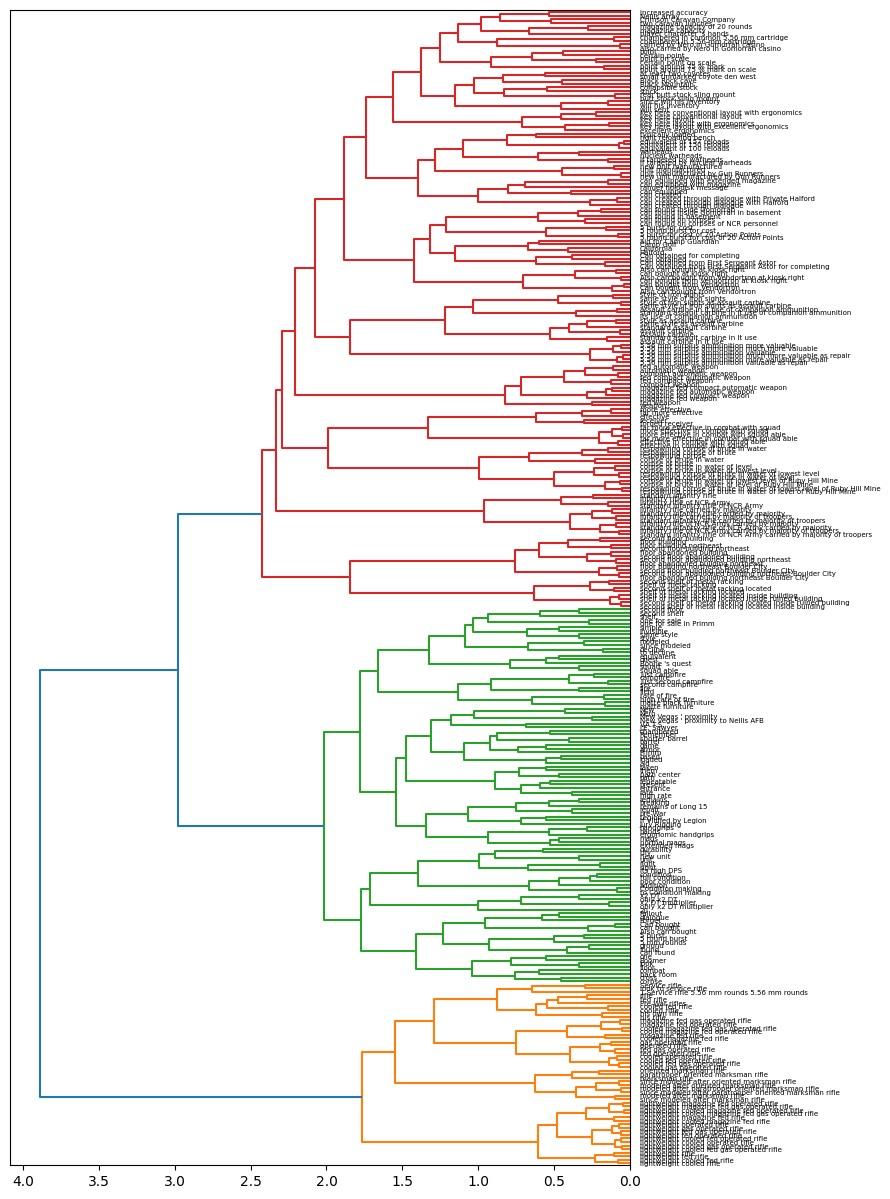

In [45]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

# TODO: слишком много всего, надо нарисовать только часть входов

plt.figure(figsize=(8, 15))
dendrogram(Z, orientation="left", labels=items)
plt.show()

In [46]:
clusters = {i: [] for i in result}

for i, idx in enumerate(result):
    clusters[idx].append(items[i])

In [47]:
for cluster in clusters:
    print("\nCluster", cluster)
    print(clusters[cluster])


Cluster 120
['Can obtained from First Sergeant Astor for completing', 'Can obtained from First Sergeant Astor']

Cluster 138
['equivalent of 150 reloads', 'equivalent of 157 reloads', 'equivalent of 100 reloads']

Cluster 159
['chambered in 5.56 mm cartridge', 'chambered in common 5.56 mm cartridge']

Cluster 3
['lightweight cooled magazine fed rifle', 'lightweight magazine fed rifle', 'lightweight magazine fed gas operated rifle', 'lightweight cooled magazine fed gas operated rifle', 'lightweight magazine fed operated rifle', 'lightweight cooled magazine fed operated rifle']

Cluster 6
['operated rifle', 'cooled gas operated rifle', 'fed operated rifle', 'cooled fed operated rifle', 'cooled operated rifle', 'cooled fed gas operated rifle', 'gas operated rifle', 'fed gas operated rifle']

Cluster 147
['butt stock sling mount', 'rear butt stock sling mount']

Cluster 60
['loaded']

Cluster 33
['to Condition making', 'Condition making']

Cluster 98
['standard infantry rifle of NCR Army'

---
## Case study 4: Червяки

In [48]:
import numpy as np

x, y = [], []

with open("worms/worms_2d.txt", "r+", encoding="utf-8") as rf:
    for line in rf:
        line = line.strip()
        if line:
            spl = line.split(" ")
            x.append(float(spl[0]))
            y.append(float(spl[1]))

x, y = np.array(x), np.array(y)
x.shape

(105600,)

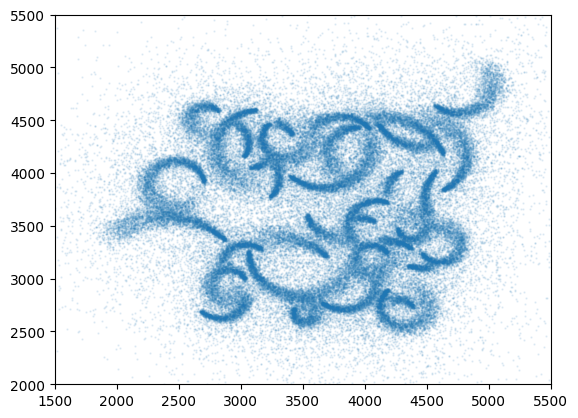

In [49]:
import matplotlib.pyplot as plt

plt.xlim(1500, 5500)
plt.ylim(2000, 5500)
plt.scatter(x, y, s=0.5, alpha=0.1)

Labels count: 35


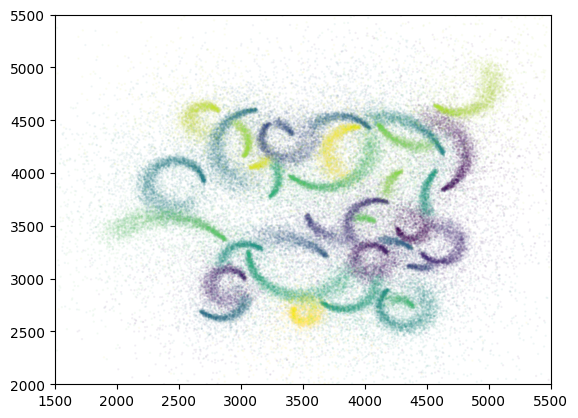

In [50]:
# еще у нас в этот раз есть правильные метки
labels = []

with open("worms/worms_2d-gt.pa", "r+", encoding="utf-8") as rf:
    for line in rf.readlines()[4:]:
        line = line.strip()
        if line:
            labels.append(int(line))

print("Labels count:", len(set(labels)))

labels = np.array(labels)

assert x.shape == labels.shape == y.shape

plt.xlim(1500, 5500)
plt.ylim(2000, 5500)
plt.scatter(x, y, s=0.5, alpha=0.05, c=labels, cmap="viridis")

Казалось бы, чего тут сложного... Давайте попробуем это кластеризовать, что ли

### Задание со звездочкой 17. Dunn index
Реализуйте Dunn Index. Будет засчитываться не абы-какая реализация, а соответствующая по стилю и оформлению реализации метрик в sklearn: обязательны докстринги, валидаторы и все такое.

То, как реализованы другие метрики, можно посмотреть [тут](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/cluster/_unsupervised.py#L195).

In [ ]:
from sklearn.utils._param_validation import (
    validate_params,
)

@validate_params(...)
def dunn_score(...):
    """
    Compute the Dunn Index by given within-cluster distances (callable or precomputed) and
    between-cluster distances(callable or precomputed).
    ...
    
    """
    ...
    return

### Задание со звездочкой 18. Кластеризация текстов

Мы сделали кластеризацию **слов** на основе их векторных представлений. На самом деле, кластеризовывать тексты гораздо сложнее и интереснее; для этой задачи существуют специальные модели, эти модели обучаются на **корпусе текстов**. Мы поговорим о таких моделях в следующем семестре, и быстро обобщим их до **тематического моделирования**, но это будет потом. А что делать, если датасета с текстами нет? Наивный подход состоит в том, чтобы как-нибудь аггрегировать векторные представления слов, например взять их среднее.

Ваша задача - предложите способ кластеризации **предложений**, который бы использовал только векторные представления слов, реализуйте и продемонстрируйте, что ваш способ работает лучше, чем наивный. 

**Подсказка:** _того, что было рассказано сегодня, должно быть достаточно, нужно только грамотно скомпоновать разные части практики._